# Test the performance of MDM vs QDM + Sort for the globe for different CMIP6 models

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask_jobqueue
import dask
from distributed import Client
from dask.diagnostics import progress
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import intake
import fsspec
import cftime
from datetime import datetime, timedelta
import pandas as pd
import xesmf as xe
import xskillscore as xs

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [ ]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [2]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [3]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [4]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [5]:
cluster.scale(6)
cluster

Dashboard: http://10.0.39.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.4:35369,Workers: 0
Dashboard: http://10.0.39.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
# calculate global means
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time") 
    
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile','model_id','obs_id'}
    return (ds * weight).mean(other_dims)

def global_mean_total(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'model_id','obs_id'}
    return (ds * weight).mean(other_dims)


In [7]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    #obs_mean   = ds_obs.mean('year')
    ds_shift   = ds_obs + (final_mean - init_mean) 
    return ds_shift 

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [8]:
ds_pi  = xr.open_zarr(cvals+'cmip6_pi_quantiles_annual.zarr').tasmax
ds_eoc = xr.open_zarr(cvals+'cmip6_eoc_quantiles_annual.zarr').tasmax
ds_eoc

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-7b83895101ae604b25277a61bd350bc4tasmax, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [9]:
ds_pi_det  = xr.open_zarr(cvals+'cmip6_pi_ann_detrended.zarr').tasmax
ds_eoc_det = xr.open_zarr(cvals+'cmip6_eoc_ann_detrended.zarr').tasmax
ds_eoc_det

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-56721fcb713521461578f60e683b9194tasmax, shape=(18, 30, 365, 61, 121), dtype=float64, chunksize=(1, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 ...
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

### Select Observation and Model indices. Compute means and stdevs

In [10]:
# %%time
# model_list = ds_eoc['source_id'].data
# obs_list   = ds_eoc['source_id'].data
# model_list

In [11]:
############ Select some ensemble as obs and another as model ######
pi_model  = ds_pi.rename({'source_id':'model_id'})
eoc_model = ds_eoc.rename({'source_id':'model_id'})
pi_model['model_id']  = pi_model['model_id'].astype(str)
eoc_model['model_id'] = eoc_model['model_id'].astype(str)
#####
pi_obs    =  ds_pi.rename({'source_id':'obs_id'})
eoc_obs   =  ds_eoc.rename({'source_id':'obs_id'})
pi_obs['obs_id']  = pi_obs['obs_id'].astype(str)
eoc_obs['obs_id'] = eoc_obs['obs_id'].astype(str)
#
pi_model_det  = ds_pi_det.rename({'source_id':'model_id'})
eoc_model_det = ds_eoc_det.rename({'source_id':'model_id'})
pi_model_det['model_id']  = pi_model_det['model_id'].astype(str)
eoc_model_det['model_id'] = eoc_model_det['model_id'].astype(str)
#
pi_obs  

<xarray.DataArray 'tasmax' (obs_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-fbbd7549f1319d482b0efea3f1b1aee9tasmax, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [12]:
pi_omean  = pi_obs.mean('year')
#
pi_mmean  = pi_model_det.mean('year')
pi_mstd   = pi_model_det.std('year')
#
eoc_mmean = eoc_model_det.mean('year')
eoc_mstd  = eoc_model_det.std('year')
pi_mmean

<xarray.DataArray 'tasmax' (model_id: 18, dayofyear: 365, lat: 61, lon: 121)>
dask.array<mean_agg-aggregate, shape=(18, 365, 61, 121), dtype=float64, chunksize=(1, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 ...
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [13]:
qpi_model  = compute_quantiles(pi_model)
qeoc_model = compute_quantiles(eoc_model)
#
qpi_obs  = compute_quantiles(pi_obs)
qeoc_obs = compute_quantiles(eoc_obs)

### Compute GMST change between pre-industrial and EOC

In [14]:
pi_model

<xarray.DataArray 'tasmax' (model_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-fbbd7549f1319d482b0efea3f1b1aee9tasmax, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [15]:
pi_gmst  = global_mean_total(pi_model)
eoc_gmst = global_mean_total(eoc_model)
eoc_gmst

<xarray.DataArray (model_id: 18)>
dask.array<mean_agg-aggregate, shape=(18,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * model_id  (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [16]:
%%time
print(pi_gmst.mean().values, eoc_gmst.mean().values)
eoc_gmst.mean().values - pi_gmst.mean().values

288.7620645218289 292.3135494005415
CPU times: user 3min 39s, sys: 8.26 s, total: 3min 47s
Wall time: 6min 58s


3.5514848787125857

## Perform Moment Delta Mapping

In [17]:
pi_mdm   = implement_mdm(pi_obs,pi_mmean,eoc_mmean,pi_mstd,eoc_mstd)
pi_shift = implement_shift(pi_obs,pi_mmean,eoc_mmean)
#
qpi_mdm    = compute_quantiles(pi_mdm)
qpi_shift = compute_quantiles(pi_shift)
#
# qpi_mdm = qpi_mdm.chunk({'obs_id':1})
qpi_shift

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(


<xarray.DataArray 'tasmax' (quantile: 30, obs_id: 18, dayofyear: 365, lat: 61,
                            lon: 121, model_id: 18)>
dask.array<transpose, shape=(30, 18, 365, 61, 121, 18), dtype=float64, chunksize=(30, 3, 92, 16, 31, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [18]:
# %%time
# qpi_mdm.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_qpi_mdm_324examples.zarr',mode='w')

In [19]:
# %%time
# qpi_shift.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_qpi_shift_306examples.zarr',mode='w')

CPU times: user 2.17 s, sys: 165 ms, total: 2.34 s
Wall time: 3.94 s


Text(0.05, 0.95, 'obs = ACCESS-CM2\nmodel= CMCC-ESM2')

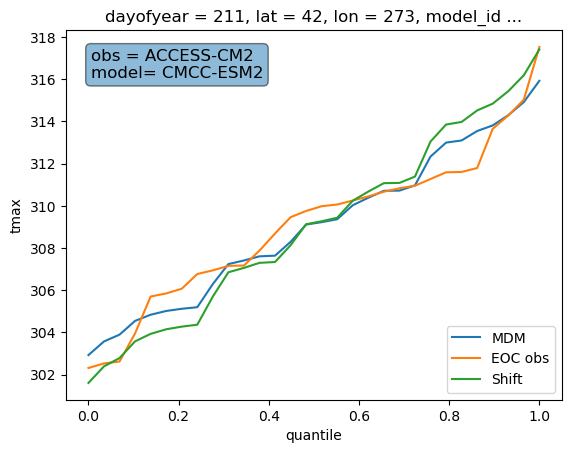

In [20]:
%%time
obs   = 'ACCESS-CM2'
model = 'CMCC-ESM2'
text_str = f'obs = {obs}\nmodel= {model}'  # Construct the text string with line breaks
#
qpi_mdm   = xr.open_zarr(cvals+'cmip6_qpi_mdm_324examples.zarr').tmax
qpi_shift = xr.open_zarr(cvals+'cmip6_qpi_shift_306examples.zarr').tmax
#
qpi_mdm.sel(lat=chic_lat,lon=chic_lon,dayofyear=doy,method='nearest').sel(model_id = 'ACCESS-CM2',obs_id ='ACCESS-CM2').plot(label='MDM')
qeoc_obs.sel(lat=chic_lat,lon=chic_lon,dayofyear=doy,method='nearest').sel(obs_id = 'ACCESS-CM2').plot(label='EOC obs')
qpi_shift.sel(lat=chic_lat,lon=chic_lon,dayofyear=doy,method='nearest').sel(model_id = 'ACCESS-CM2',obs_id ='ACCESS-CM2').plot(label='Shift')
plt.legend(loc='lower right')
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

## Perform Quantile Delta Mapping

In [21]:
qano     = qeoc_model - qpi_model
qano

<xarray.DataArray 'tasmax' (quantile: 30, model_id: 18, dayofyear: 365,
                            lat: 61, lon: 121)>
dask.array<sub, shape=(30, 18, 365, 61, 121), dtype=float64, chunksize=(30, 3, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [22]:
qpi_qdm =  qpi_obs + qano
qpi_qdm = qpi_qdm.chunk({'obs_id':1})
qpi_qdm

<xarray.DataArray 'tasmax' (quantile: 30, obs_id: 18, dayofyear: 365, lat: 61,
                            lon: 121, model_id: 18)>
dask.array<rechunk-merge, shape=(30, 18, 365, 61, 121, 18), dtype=float64, chunksize=(30, 1, 92, 16, 31, 3), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [23]:
# %%time
# qpi_qdm.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_qpi_qdm_324examples.zarr',mode='w')

In [24]:
qpi_qdm = xr.open_zarr(cvals+'cmip6_qpi_qdm_324examples.zarr').tmax

## Select model and observations and plot

In [25]:
qpi_sqdm  = xr.apply_ufunc(
    np.sort,
    qpi_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
qpi_sqdm

<xarray.DataArray 'tmax' (obs_id: 18, dayofyear: 365, lat: 61, lon: 121,
                          model_id: 18, quantile: 30)>
dask.array<transpose, shape=(18, 365, 61, 121, 18, 30), dtype=float64, chunksize=(1, 92, 16, 31, 3, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

### Results for Bengaluru, July 30

In [26]:
model_name = 'ACCESS-CM2'
obs_name   = 'MIROC6'
# Pick lat lon
LAT = ben_lat
LON = ben_lon
location = 'Bengaluru'

In [27]:
%%time
# Calculate quantile curves for Bengaluru
#
qpi_mdm_day    = qpi_mdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                  .sel(model_id = model_name).sel(obs_id = obs_name)
#
qpi_qdm_day    = qpi_qdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                    .sel(model_id = model_name).sel(obs_id = obs_name)
#
#
qpi_shift_day    = qpi_shift.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                  .sel(model_id = model_name).sel(obs_id = obs_name)
#
# qeoc_model_day = qeoc_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_index)
#
qpi_sqdm_day   = qpi_sqdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                .sel(model_id = model_name).sel(obs_id = obs_name)
qpi_model_day  = qpi_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_name)
qpi_obs_day    = qpi_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)
qeoc_obs_day   = qeoc_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)

CPU times: user 967 ms, sys: 27.4 ms, total: 994 ms
Wall time: 1.01 s


CPU times: user 3.04 s, sys: 152 ms, total: 3.2 s
Wall time: 6.51 s


Text(0.05, 0.95, 'obs = MIROC6\nmodel= ACCESS-CM2')

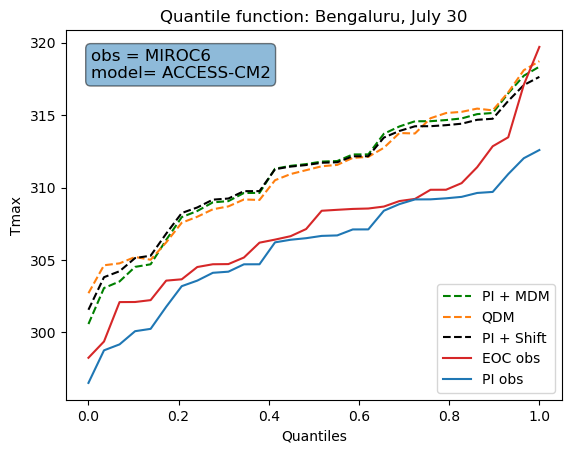

In [28]:
%%time
#
text_str = f'obs = {obs_name}\nmodel= {model_name}'  # Construct the text string with line breaks
#
plt.plot(quants,qpi_mdm_day,'--',color='green',label='PI + MDM')
plt.plot(quants,qpi_qdm_day,'--',color='tab:orange',label='QDM')
plt.plot(quants,qpi_shift_day,'--',color='black',label='PI + Shift')
plt.plot(quants,qeoc_obs_day,color='tab:red',label ='EOC obs')
plt.plot(quants,qpi_obs_day,color= 'tab:blue', label ='PI obs')
#
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('Quantile function: '+ location + ', ' + date)
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

In [29]:
is_sorted(qpi_qdm_day.values)

False

In [30]:
%%time
rmse_qdm_day = xs.rmse(qpi_qdm_day,qeoc_obs_day,dim = 'quantile')
rmse_mdm_day = xs.rmse(qpi_mdm_day,qeoc_obs_day,dim = 'quantile')
rmse_sqdm_day = xs.rmse(qpi_sqdm_day,qeoc_obs_day,dim = 'quantile')
print(rmse_mdm_day.values,rmse_qdm_day.values,rmse_sqdm_day.values)

3.8211589825646395 3.7731836071194853 3.7710700415093603
CPU times: user 11.6 s, sys: 460 ms, total: 12.1 s
Wall time: 29.8 s


### Results for Chicago, July 30

In [31]:
model_name = 'ACCESS-CM2'
obs_name   = 'NorESM2-MM'
# Pick lat lon
LAT = chic_lat
LON = chic_lon
location = 'Chicago'

In [32]:
%%time
# Calculate quantile curves for Bengaluru
#
qpi_mdm_day    = qpi_mdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                  .sel(model_id = model_name).sel(obs_id = obs_name)
#
qpi_qdm_day    = qpi_qdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                    .sel(model_id = model_name).sel(obs_id = obs_name)
#
qpi_shift_day    = qpi_shift.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                  .sel(model_id = model_name).sel(obs_id = obs_name)
#
# qeoc_model_day = qeoc_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_index)
#
qpi_sqdm_day = qpi_sqdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                .sel(model_id = model_name).sel(obs_id = obs_name)
qpi_model_day  = qpi_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_name)
qpi_obs_day    = qpi_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)
qeoc_obs_day   = qeoc_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)

CPU times: user 219 ms, sys: 13.7 ms, total: 233 ms
Wall time: 229 ms


CPU times: user 2.93 s, sys: 127 ms, total: 3.05 s
Wall time: 6.12 s


Text(0.05, 0.95, 'obs = NorESM2-MM\nmodel= ACCESS-CM2')

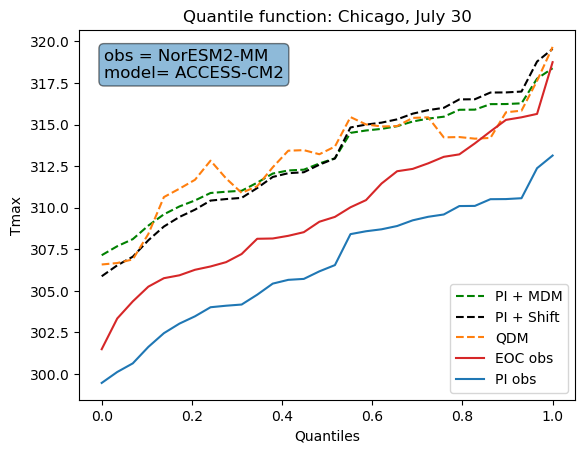

In [33]:
%%time
#
text_str = f'obs = {obs_name}\nmodel= {model_name}'  # Construct the text string with line breaks
#
plt.plot(quants,qpi_mdm_day,'--',color='green',label='PI + MDM')
plt.plot(quants,qpi_shift_day,'--',color='black',label='PI + Shift')
plt.plot(quants,qpi_qdm_day,'--',color='tab:orange',label='QDM')
plt.plot(quants,qeoc_obs_day,color='tab:red',label ='EOC obs')
plt.plot(quants,qpi_obs_day,color= 'tab:blue', label ='PI obs')
#
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('Quantile function: '+ location + ', ' + date)
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

In [34]:
is_sorted(qpi_qdm_day.values)

False

In [35]:
%%time
rmse_qdm_day = xs.rmse(qpi_qdm_day,qeoc_obs_day,dim = 'quantile')
rmse_mdm_day = xs.rmse(qpi_mdm_day,qeoc_obs_day,dim = 'quantile')
rmse_sqdm_day = xs.rmse(qpi_sqdm_day,qeoc_obs_day,dim = 'quantile')
print(rmse_mdm_day.values,rmse_qdm_day.values,rmse_sqdm_day.values)

3.451364145165458 3.7428197863454975 3.6066613886825043
CPU times: user 8.96 s, sys: 382 ms, total: 9.34 s
Wall time: 22.6 s


### Compute global mean of absolute error 
- Quantile function after applying mdm on model pre-ind quantile function is denoted qpi_mdm using some qeoc_obs
- `Observed' end-of-21st-century quantile function is qeoc_obs
- Therefore, error for a give model and obs pair is defined as qpi_mdm - qeoc_obs. 
- Here, qeoc_obs0 is used instead of qeoc_obs to implement this computation using xarray broadcasting
- We then take the absolute value of this quantitiy and compute global mean

In [36]:
mdm_abserr   = np.fabs(qeoc_obs - qpi_mdm)
shift_abserr = np.fabs(qeoc_obs - qpi_shift)
mdm_abserr 

<xarray.DataArray (quantile: 30, obs_id: 18, dayofyear: 365, lat: 61, lon: 121,
                   model_id: 18)>
dask.array<fabs, shape=(30, 18, 365, 61, 121, 18), dtype=float64, chunksize=(30, 3, 92, 16, 31, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [37]:
# Mean absolute Error, where mean is global and annual mean
mdm_mae   = global_mean(mdm_abserr)
shift_mae = global_mean(shift_abserr)
mdm_mae

<xarray.DataArray (quantile: 30, obs_id: 18, model_id: 18)>
dask.array<mean_agg-aggregate, shape=(30, 18, 18), dtype=float64, chunksize=(30, 3, 1), chunktype=numpy.ndarray>
Coordinates:
  * obs_id    (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * model_id  (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [38]:
%%time
# mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_mdm_mae_324examples.zarr',mode='w')
# shift_mae.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_shift_mae_306examples.zarr',mode='w')

CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 27.4 µs


Text(0.5, 1.0, 'MDM and Shift-only')

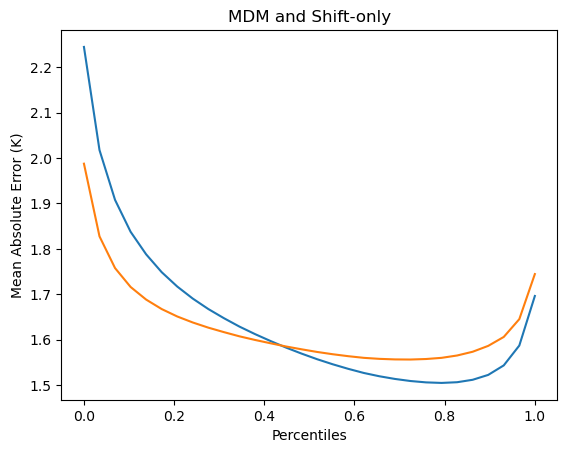

In [39]:
mdm_mae   = xr.open_zarr(cvals+'cmip6_mdm_mae_324examples.zarr').tmax
shift_mae = xr.open_zarr(cvals+'cmip6_shift_mae_306examples.zarr').tmax
#
mdm_mae.sel(model_id=model_name,obs_id=obs_name).plot()
shift_mae.sel(model_id=model_name,obs_id=obs_name).plot()
plt.ylabel('Mean Absolute Error (K)')
plt.xlabel('Percentiles')
plt.title('MDM and Shift-only')

### Calculate Mean Absolute Error for sorted QDM

In [40]:
sqdm_abserr = np.fabs(qeoc_obs - qpi_sqdm)
sqdm_mae = global_mean(sqdm_abserr)

In [41]:
# %%time
# sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_sqdm_mae_324examples.zarr',mode='w')

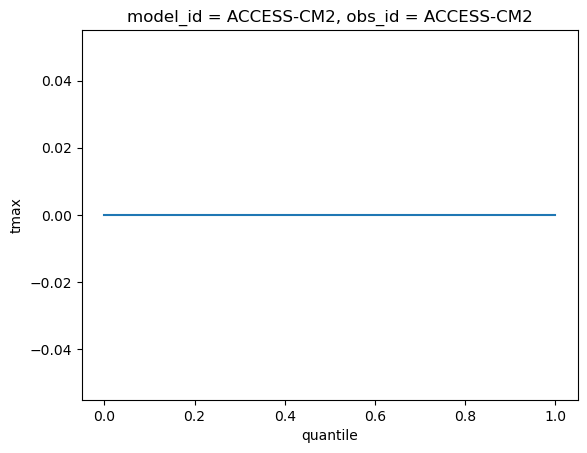

In [42]:
sqdm_mae = xr.open_zarr(cvals+'cmip6_sqdm_mae_324examples.zarr').tmax
sqdm_mae.sel(model_id=model_name,obs_id=model_name).plot()

## Calculate mean of mean absolute error over (obs_id,model_id) pairs 
 - Recall that MAE for a given (obs,model) pair is computed as a global mean and mean overy days of the year.

In [43]:
%%time
# Create a mask where 'obs_id' and 'model_id' do not match
mask = xr.DataArray(
    [[obs != model for model in mdm_mae.model_id.values] for obs in mdm_mae.obs_id.values], 
    dims=['obs_id', 'model_id'], 
    coords={'obs_id': mdm_mae.obs_id, 'model_id': mdm_mae.model_id}
)

# Expand mask to align with the quantile dimension
mask = mask.expand_dims({'quantile':mdm_mae['quantile'].values})

# # Apply the mask to the data array
# masked_da = mdm_mae.where(mask)
mask

CPU times: user 17.8 ms, sys: 1.06 ms, total: 18.9 ms
Wall time: 16.6 ms


<xarray.DataArray (quantile: 30, obs_id: 18, model_id: 18)>
array([[[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
...
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]]])
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * obs_id    (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * model_id  (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [44]:
# Apply the mask to the data array
masked_mdm_mae   = mdm_mae.where(mask)
masked_sqdm_mae  = sqdm_mae.where(mask)
masked_shift_mae = shift_mae.where(mask)
masked_sqdm_mae

<xarray.DataArray 'tmax' (quantile: 30, obs_id: 18, model_id: 18)>
dask.array<where, shape=(30, 18, 18), dtype=float64, chunksize=(30, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * model_id  (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * obs_id    (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [45]:
# Calculate the mean over 'obs_id' and 'model_id' where values do not match
average_mdm_mae    = masked_mdm_mae.mean(dim=['obs_id', 'model_id'],skipna=True)
average_sqdm_mae   = masked_sqdm_mae.mean(dim=['obs_id', 'model_id'],skipna=True)
average_shift_mae  = masked_shift_mae.mean(dim=['obs_id', 'model_id'],skipna=True)

In [46]:
# %%time
# average_mdm_mae.to_dataset().to_zarr(cvals  + 'cmip6_mdm_mae_avg324pairs.zarr',mode='w')
# average_sqdm_mae.to_dataset().to_zarr(cvals + 'cmip6_sqdm_mae_avg324pairs.zarr',mode='w')
# average_mdm_mae.to_dataset().to_zarr(cvals  + 'cmip6_mdm_mae_avg306pairs.zarr',mode='w')
# average_sqdm_mae.to_dataset().to_zarr(cvals + 'cmip6_sqdm_mae_avg306pairs.zarr',mode='w')
# average_shift_mae.to_dataset().to_zarr(cvals  + 'cmip6_shift_mae_avg306pairs.zarr',mode='w')

In [47]:
#
average_mdm_mae    = xr.open_zarr(cvals + 'cmip6_mdm_mae_avg306pairs.zarr').tmax
average_sqdm_mae   = xr.open_zarr(cvals + 'cmip6_sqdm_mae_avg306pairs.zarr').tmax
average_shift_mae  = xr.open_zarr(cvals + 'cmip6_shift_mae_avg306pairs.zarr').tmax

In [48]:
%%time
qano_std_agmean = xr.open_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr').tasmax_qanomaly
qano_std_agmean

CPU times: user 20.7 ms, sys: 8.9 ms, total: 29.6 ms
Wall time: 29.9 ms


<xarray.DataArray 'tasmax_qanomaly' (quantile: 30)>
dask.array<open_dataset-c74e3e8a723ef9a61a73108437f08b47tasmax_qanomaly, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

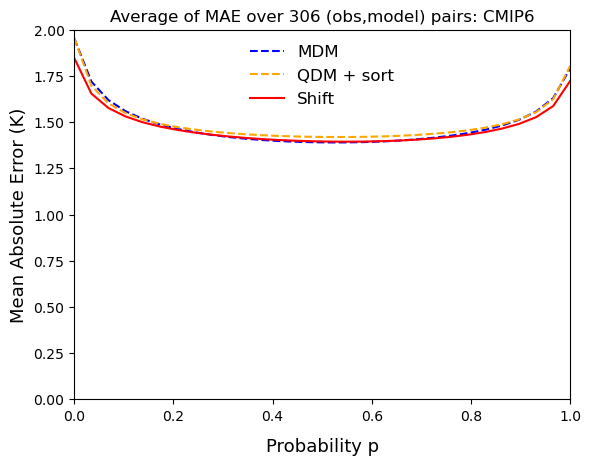

CPU times: user 1.72 s, sys: 126 ms, total: 1.85 s
Wall time: 1.87 s


In [49]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
#plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.plot(quants30,average_shift_mae,label='Shift', color = 'red')
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('Average of MAE over 306 (obs,model) pairs: CMIP6')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

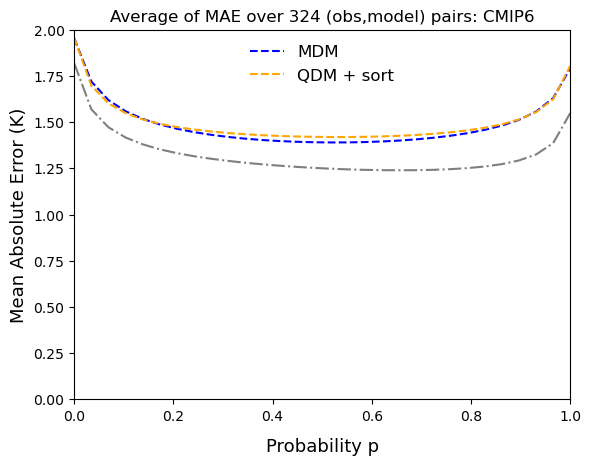

CPU times: user 1.77 s, sys: 113 ms, total: 1.88 s
Wall time: 1.83 s


In [50]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('Average of MAE over 324 (obs,model) pairs: CMIP6')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()